[Tutorial](https://pennylane.ai/qml/demos/tutorial_learning_few_data#training-the-qcnn-on-the-digits-dataset)

Imports needed

In [68]:
%matplotlib inline


import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
import seaborn as sns
import jax

jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import optax  # optimization using jax

import pennylane as qml
import pennylane.numpy as pnp

sns.set()

seed = 0
rng = np.random.default_rng(seed=seed)
jax.__version__

'0.4.33'

QCNN layer:

In [69]:
def convolutional_layer(weights, wires, skip_first_layer=True):
    """Adds a convolutional layer to a circuit.
    Args:
        weights (np.array): 1D array with 15 weights of the parametrized gates.
        wires (list[int]): Wires where the convolutional layer acts on.
        skip_first_layer (bool): Skips the first two U3 gates of a layer.
    """
    n_wires = len(wires)
    assert n_wires >= 3, "this circuit is too small!"

    for p in [0, 1]:
        for indx, w in enumerate(wires):
            if indx % 2 == p and indx < n_wires - 1:
                if indx % 2 == 0 and not skip_first_layer:
                    qml.U3(*weights[:3], wires=[w])
                    qml.U3(*weights[3:6], wires=[wires[indx + 1]])
                qml.IsingXX(weights[6], wires=[w, wires[indx + 1]])
                qml.IsingYY(weights[7], wires=[w, wires[indx + 1]])
                qml.IsingZZ(weights[8], wires=[w, wires[indx + 1]])
                qml.U3(*weights[9:12], wires=[w])
                qml.U3(*weights[12:], wires=[wires[indx + 1]])


def pooling_layer(weights, wires):
    """Adds a pooling layer to a circuit.
    Args:
        weights (np.array): Array with the weights of the conditional U3 gate.
        wires (list[int]): List of wires to apply the pooling layer on.
    """
    n_wires = len(wires)
    assert len(wires) >= 2, "this circuit is too small!"

    for indx, w in enumerate(wires):
        if indx % 2 == 1 and indx < n_wires:
            m_outcome = qml.measure(w)
            qml.cond(m_outcome, qml.U3)(*weights, wires=wires[indx - 1])
            # # Versione deferred:
            # qml.ctrl(qml.U3, (w), control_values=(1))(*weights, wires=wires[indx - 1])


def conv_and_pooling(kernel_weights, n_wires, skip_first_layer=True):
    """Apply both the convolutional and pooling layer."""
    convolutional_layer(kernel_weights[:15], n_wires, skip_first_layer=skip_first_layer)
    pooling_layer(kernel_weights[15:], n_wires)


def dense_layer(weights, wires):
    """Apply an arbitrary unitary gate to a specified set of wires."""
    qml.ArbitraryUnitary(weights, wires)


Defining QCNN

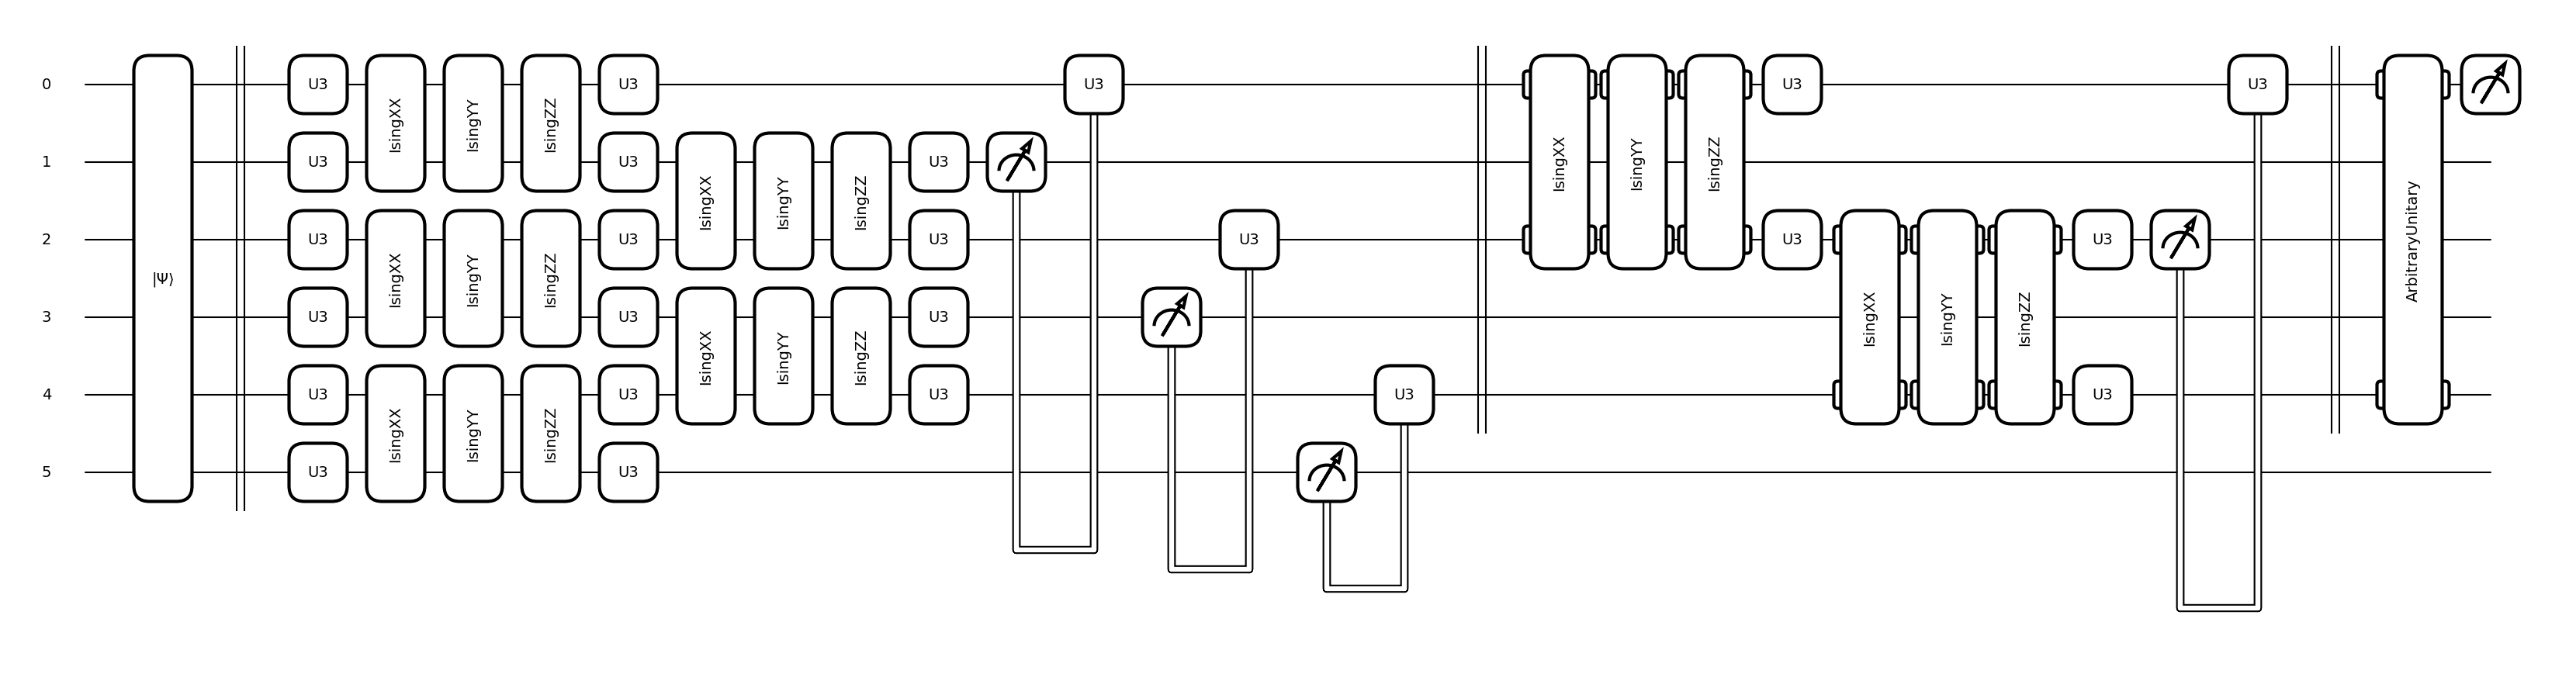

In [70]:

num_wires = 6
device = qml.device("default.qubit", wires=num_wires)


@qml.qnode(device)
def conv_net(weights, last_layer_weights, features):
    """Define the QCNN circuit
    Args:
        weights (np.array): Parameters of the convolution and pool layers.
        last_layer_weights (np.array): Parameters of the last dense layer.
        features (np.array): Input data to be embedded using AmplitudEmbedding."""

    layers = weights.shape[1]
    wires = list(range(num_wires))


    # inputs the state input_state
    qml.AmplitudeEmbedding(features=features, wires=wires, pad_with=0.5)
    qml.Barrier(wires=wires, only_visual=True)

    # adds convolutional and pooling layers
    for j in range(layers):
        conv_and_pooling(weights[:, j], wires, skip_first_layer=(not j == 0))
        wires = wires[::2]
        qml.Barrier(wires=wires, only_visual=True)

    assert last_layer_weights.size == 4 ** (len(wires)) - 1, (
        "The size of the last layer weights vector is incorrect!"
        f" \n Expected {4 ** (len(wires)) - 1}, Given {last_layer_weights.size}"
    )
    dense_layer(last_layer_weights, wires)
    return qml.probs(wires=(0))


fig, ax = qml.draw_mpl(conv_net)(
    np.random.rand(18, 2), np.random.rand(4 ** 2 - 1), np.random.rand(2 ** num_wires)
)
plt.show()

In [71]:
digits = datasets.load_digits()
images, labels = digits.data, digits.target

images = images[np.where((labels == 0) | (labels == 1))]
labels = labels[np.where((labels == 0) | (labels == 1))]

print(np.shape(images))

def load_digits_data(num_train, num_test, rng):
    """Return training and testing data of digits dataset."""
    digits = datasets.load_digits()
    features, labels = digits.data, digits.target

    # only use first two classes
    features = features[np.where((labels == 0) | (labels == 1))]
    labels = labels[np.where((labels == 0) | (labels == 1))]

    # normalize data
    features = features / np.linalg.norm(features, axis=1).reshape((-1, 1))

    # subsample train and test split
    train_indices = rng.choice(len(labels), num_train, replace=False)
    test_indices = rng.choice(
        np.setdiff1d(range(len(labels)), train_indices), num_test, replace=False
    )

    x_train, y_train = features[train_indices], labels[train_indices]
    x_test, y_test = features[test_indices], labels[test_indices]

    return (
        jnp.asarray(x_train),
        jnp.asarray(y_train),
        jnp.asarray(x_test),
        jnp.asarray(y_test),
    )


@jax.jit
def compute_out(weights, weights_last, features, labels):
    """Computes the output of the corresponding label in the qcnn"""
    cost = lambda weights, weights_last, feature, label: conv_net(weights, weights_last, feature)[
        label
    ]
    return jax.vmap(cost, in_axes=(None, None, 0, 0), out_axes=0)(
        weights, weights_last, features, labels
    )


def compute_accuracy(weights, weights_last, features, labels):
    """Computes the accuracy over the provided features and labels"""
    out = compute_out(weights, weights_last, features, labels)
    return jnp.sum(out > 0.5) / len(out)


def compute_cost(weights, weights_last, features, labels):
    """Computes the cost over the provided features and labels"""
    out = compute_out(weights, weights_last, features, labels)
    return 1.0 - jnp.sum(out) / len(labels)


def init_weights():
    """Initializes random weights for the QCNN model."""
    weights = pnp.random.normal(loc=0, scale=1, size=(18, 2), requires_grad=True)
    weights_last = pnp.random.normal(loc=0, scale=1, size=4 ** 2 - 1, requires_grad=True)
    return jnp.array(weights), jnp.array(weights_last)


value_and_grad = jax.jit(jax.value_and_grad(compute_cost, argnums=[0, 1]))


def train_qcnn(n_train, n_test, n_epochs):
    """
    Args:
        n_train  (int): number of training examples
        n_test   (int): number of test examples
        n_epochs (int): number of training epochs
        desc  (string): displayed string during optimization

    Returns:
        dict: n_train,
        steps,
        train_cost_epochs,
        train_acc_epochs,
        test_cost_epochs,
        test_acc_epochs

    """
    # load data
    x_train, y_train, x_test, y_test = load_digits_data(n_train, n_test, rng)

    # init weights and optimizer
    weights, weights_last = init_weights()

    # learning rate decay
    cosine_decay_scheduler = optax.cosine_decay_schedule(0.1, decay_steps=n_epochs, alpha=0.95)
    optimizer = optax.adam(learning_rate=cosine_decay_scheduler)
    opt_state = optimizer.init((weights, weights_last))

    # data containers
    train_cost_epochs, test_cost_epochs, train_acc_epochs, test_acc_epochs = [], [], [], []

    for step in range(n_epochs):
        # Training step with (adam) optimizer
        train_cost, grad_circuit = value_and_grad(weights, weights_last, x_train, y_train)
        updates, opt_state = optimizer.update(grad_circuit, opt_state)
        weights, weights_last = optax.apply_updates((weights, weights_last), updates)
        train_cost_epochs.append(train_cost)

        # TODO: here the weights to save

        # compute accuracy on training data
        train_acc = compute_accuracy(weights, weights_last, x_train, y_train)
        train_acc_epochs.append(train_acc)

        # compute accuracy and cost on testing data
        test_out = compute_out(weights, weights_last, x_test, y_test)
        test_acc = jnp.sum(test_out > 0.5) / len(test_out)
        test_acc_epochs.append(test_acc)
        test_cost = 1.0 - jnp.sum(test_out) / len(test_out)
        test_cost_epochs.append(test_cost)

    # print(f'\t {test_acc:.3f} \t {train_acc:.3f}')


    return dict(
        n_train=[n_train] * n_epochs,
        step=np.arange(1, n_epochs + 1, dtype=int),
        train_cost=train_cost_epochs,
        train_acc=train_acc_epochs,
        test_cost=test_cost_epochs,
        test_acc=test_acc_epochs,
    )

(360, 64)


In [72]:
n_test = 100
n_epochs = 100
n_reps = 100


def run_iterations(n_train):
    results_df = pd.DataFrame(
        columns=["train_acc", "train_cost", "test_acc", "test_cost", "step", "n_train"]
    )

    for rep in range(n_reps):
        # print(f'{rep} \t Test_Acc \t Train_Acc')
        results = train_qcnn(n_train=n_train, n_test=n_test, n_epochs=n_epochs)
        results_df = pd.concat(
            [results_df, pd.DataFrame.from_dict(results)], axis=0, ignore_index=True
        )

    return results_df


# run training for multiple sizes
train_sizes = [80]
print(f"Running training for n_train={train_sizes[0]}")
results_df = run_iterations(n_train=train_sizes[0])
for n_train in train_sizes[1:]:
    print(f"Running training for n_train={n_train}")
    results_df = pd.concat([results_df, run_iterations(n_train=n_train)])
print('Done')

Running training for n_train=80
0 	 Test_Acc 	 Train_Acc
	 1.000 	 0.988
1 	 Test_Acc 	 Train_Acc
	 1.000 	 1.000
2 	 Test_Acc 	 Train_Acc
	 1.000 	 0.988
3 	 Test_Acc 	 Train_Acc
	 0.960 	 0.963
4 	 Test_Acc 	 Train_Acc
	 0.940 	 0.963
5 	 Test_Acc 	 Train_Acc
	 0.950 	 0.988
6 	 Test_Acc 	 Train_Acc
	 0.970 	 0.975
7 	 Test_Acc 	 Train_Acc
	 1.000 	 0.988
8 	 Test_Acc 	 Train_Acc
	 0.990 	 0.988
9 	 Test_Acc 	 Train_Acc
	 1.000 	 1.000
10 	 Test_Acc 	 Train_Acc
	 1.000 	 1.000
11 	 Test_Acc 	 Train_Acc
	 0.950 	 0.988
12 	 Test_Acc 	 Train_Acc
	 0.930 	 0.975
13 	 Test_Acc 	 Train_Acc
	 0.990 	 1.000
14 	 Test_Acc 	 Train_Acc
	 0.980 	 0.963
15 	 Test_Acc 	 Train_Acc
	 0.980 	 1.000
16 	 Test_Acc 	 Train_Acc
	 0.970 	 0.963
17 	 Test_Acc 	 Train_Acc
	 1.000 	 1.000
18 	 Test_Acc 	 Train_Acc
	 1.000 	 1.000
19 	 Test_Acc 	 Train_Acc
	 1.000 	 1.000
20 	 Test_Acc 	 Train_Acc
	 0.960 	 0.975
21 	 Test_Acc 	 Train_Acc
	 0.960 	 0.975
22 	 Test_Acc 	 Train_Acc
	 0.990 	 1.000
23 	 Test_Ac

KeyboardInterrupt: 

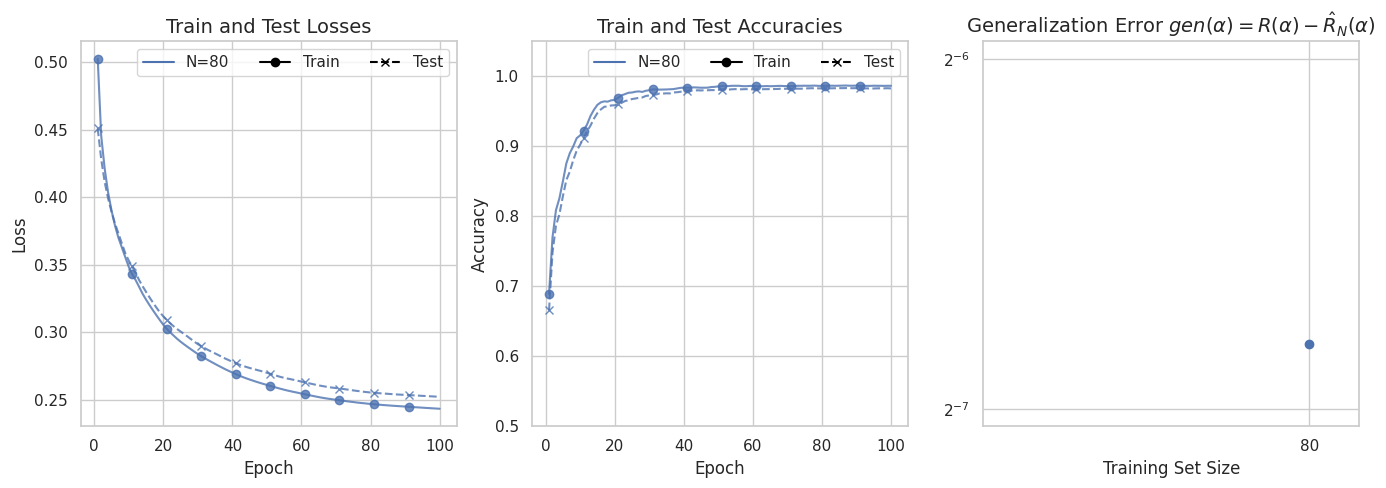

In [67]:
# aggregate dataframe
df_agg = results_df.groupby(["n_train", "step"]).agg(["mean", "std"])
df_agg = df_agg.reset_index()

sns.set_style('whitegrid')
colors = sns.color_palette()
fig, axes = plt.subplots(ncols=3, figsize=(16.5, 5))

generalization_errors = []

# plot losses and accuracies
for i, n_train in enumerate(train_sizes):
    df = df_agg[df_agg.n_train == n_train]

    dfs = [df.train_cost["mean"], df.test_cost["mean"], df.train_acc["mean"], df.test_acc["mean"]]
    lines = ["o-", "x--", "o-", "x--"]
    labels = [fr"$N={n_train}$", None, fr"$N={n_train}$", None]
    axs = [0,0,1,1]
    
    for k in range(4):
        ax = axes[axs[k]]   
        ax.plot(df.step, dfs[k], lines[k], label=labels[k], markevery=10, color=colors[i], alpha=0.8)


    # plot final loss difference
    dif = df[df.step == 100].test_cost["mean"] - df[df.step == 100].train_cost["mean"]
    generalization_errors.append(dif)

# format loss plot
ax = axes[0]
ax.set_title('Train and Test Losses', fontsize=14)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')



# format loss plot
ax = axes[1]
ax.set_title('Train and Test Accuracies', fontsize=14)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.5, 1.05)

legend_elements = [
    mpl.lines.Line2D([0], [0], label=f'N={n}', color=colors[i]) for i, n in enumerate(train_sizes)
    ] + [
    mpl.lines.Line2D([0], [0], marker='o', ls='-', label='Train', color='Black'),
    mpl.lines.Line2D([0], [0], marker='x', ls='--', label='Test', color='Black')
    ]

axes[0].legend(handles=legend_elements, ncol=3)
axes[1].legend(handles=legend_elements, ncol=3)

# format generalization error plot
ax = axes[2]
ax.plot(train_sizes, generalization_errors, "o-", label=r"$gen(\alpha)$")
ax.set_xscale('log')
ax.set_xticks(train_sizes)
ax.set_xticklabels(train_sizes)
ax.set_title(r'Generalization Error $gen(\alpha) = R(\alpha) - \hat{R}_N(\alpha)$', fontsize=14)
ax.set_xlabel('Training Set Size')
axes[2].set_yscale('log', base=2)
plt.show()

80 is the best!